In [ ]:
import warnings
import numpy as np
import pandas as pd
import plotly as py
import plotly.express as px
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
from scipy.stats import zscore
from sklearn.cluster import KMeans,AgglomerativeClustering,AffinityPropagation, DBSCAN, OPTICS, MeanShift, SpectralClustering
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score,silhouette_samples, calinski_harabasz_score
from scipy import stats
import scipy.cluster.hierarchy as sch
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter
from scipy.cluster.hierarchy import linkage, fcluster
import math
import time
np.set_printoptions(suppress=False, precision=2, formatter={'float_kind':'{:0.5e}'.format})
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
base = pd.read_csv('/content/online_retail_II.csv', encoding = 'unicode_escape')
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [ ]:
len(base['Customer ID'].unique()), len(base['Customer ID']), len(base['Invoice'].unique())

(5943, 1067371, 53628)

In [ ]:
base[(base["Price"]== 0.0) & (base['Quantity']>0)]
# base.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
3161,489659,21350,NaN,230,2009-12-01 17:39:00,0.0,NaN,United Kingdom
3731,489781,84292,NaN,17,2009-12-02 11:45:00,0.0,NaN,United Kingdom
4674,489825,22076,6 RIBBONS EMPIRE,12,2009-12-02 13:34:00,0.0,16126.0,United Kingdom
5904,489861,DOT,DOTCOM POSTAGE,1,2009-12-02 14:50:00,0.0,NaN,United Kingdom
6378,489882,35751C,NaN,12,2009-12-02 16:22:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
1060795,581211,22142,check,14,2011-12-07 18:36:00,0.0,NaN,United Kingdom
1062442,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,NaN,United Kingdom
1063965,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,0.0,NaN,United Kingdom
1063966,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.0,NaN,United Kingdom


### Remoção de informação imprecisas

In [ ]:
# Remover Customer ID nulos
base.dropna(subset = ['Customer ID'], inplace = True)
len(base)

824364

In [ ]:
# Remover teste e inserções manuais inconsistentes

# teste = base[(base['Description']  == 'This is a test product.') | ((base['Description'] == 'Manual') & (base['Price'] == 0.0))]
# teste.to_csv('teste.csv', index = False)
base = base[~((base['Description']  == 'This is a test product.') | ((base['Description'] == 'Manual') & (base['Price'] == 0.0)))].reset_index(drop = True)
# base.head()
len(base)

824341

In [ ]:
# Remover os cancelados

cancelados = base[base['Invoice'].str.contains('C')]['Invoice'].unique()
base = base[~base['Invoice'].isin(cancelados)]
len(base)

805601

In [ ]:
# Remover os diplicados

base.drop_duplicates(inplace = True)
len(base)

779476

In [ ]:
base[base['Price']==0].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
3754,489825,22076,6 RIBBONS EMPIRE,12,2009-12-02 13:34:00,0.0,16126.0,United Kingdom
4889,489998,48185,DOOR MAT FAIRY CAKE,2,2009-12-03 11:19:00,0.0,15658.0,United Kingdom
14557,490961,22065,CHRISTMAS PUDDING TRINKET POT,1,2009-12-08 15:25:00,0.0,14108.0,United Kingdom
14558,490961,22142,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-08 15:25:00,0.0,14108.0,United Kingdom
24542,492079,85042,ANTIQUE LILY FAIRY LIGHTS,8,2009-12-15 13:49:00,0.0,15070.0,United Kingdom


In [ ]:
# Reaproveitamento de dados

# Criação de tabela com preços médios por país e StockCode
precos_medios = base[base['Price'] > 0].groupby(['StockCode','Country'])['Price'].mean().reset_index()

base = base.merge(precos_medios, on=['StockCode', 'Country'], how='left')
base.rename(columns = {'Price_y':'Preco_Medio', 'Price_x':'Price'}, inplace = True)

base['Price'] = base.apply(lambda row: row['Preco_Medio'] if row['Price'] == 0.0 else row['Price'], axis=1).round(2)
base.drop(columns=['Preco_Medio'], inplace=True)

In [ ]:
base = base[base['Price']>0]
len(base)

779456

In [ ]:
len(base['Customer ID'].unique()), len(base['Customer ID']), len(base['Invoice'].unique())

(5879, 779456, 36962)

### Análise exploratória dos dados

In [ ]:
base['InvoiceDate'] = pd.to_datetime(base['InvoiceDate'])
base['Customer ID'] = base['Customer ID'].astype(int)
base['Total'] = base['Price'] * base['Quantity']

In [ ]:
compras_por_dia = base.set_index('InvoiceDate').resample('D').count().reset_index()
compras_por_mes = base.set_index('InvoiceDate').resample('MS').count().reset_index()
compras_por_mes['Month'] = compras_por_mes['InvoiceDate'].dt.strftime('%b %Y')

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Volume por dia', 'Volume por mês'),
    horizontal_spacing=0.15
)

fig.add_trace(go.Bar(
    x=compras_por_dia['InvoiceDate'],
    y=compras_por_dia['Quantity'],
    name='Compras por Dia',
    marker_color='#053061',
), row=1, col=1)

fig.add_trace(go.Bar(
    x=compras_por_mes['Month'],
    y=compras_por_mes['Quantity'],
    name='Compras por Mês',
    marker_color='#8297B0',
    marker_line_color='black',
), row=1, col=2)

fig.update_xaxes(
    title_text='Data', tickangle=45, tickmode='auto', nticks=10, row=1, col=1
)
fig.update_yaxes(title_text='Volume de Vendas', row=1, col=1)

fig.update_xaxes(
    title_text='Data', tickangle=45, tickmode='auto', nticks=10, row=1, col=2
)
fig.update_yaxes(title_text='Volume de Vendas', row=1, col=2)

fig.update_layout(
    title={
        'text': "Distribuição de vendas no período",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    title_font=dict(size=23, color='black'),
    width=1200,
    height=500,
    showlegend=False,
    template='plotly_white',
    font=dict(size=11, color='black'),
    hovermode='x unified',
    hoverlabel=dict(font_size=12),
    hoverdistance=100,
    spikedistance=1000,
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()

In [ ]:
# Primeiro e último dia
min(base['InvoiceDate']),max(base['InvoiceDate'])

(Timestamp('2009-12-01 07:45:00'), Timestamp('2011-12-09 12:50:00'))

In [ ]:
# Define a data referência e calcula a recência
base['Recencia'] = (pd.to_datetime('2011-12-10') - base['InvoiceDate']).dt.days

### Base RFV

In [ ]:
rfv = base.groupby('Customer ID').agg({
    'Recencia': 'min',
    'Invoice': 'nunique',
    'Total' : 'sum'}).reset_index()

rfv = rfv.rename(columns={
    'Customer ID': 'Cliente',
    'Invoice' : 'Frequencia',
    'Total': 'Valor'})

In [ ]:
rfv['Valor'] = rfv['Valor'].astype(int)
rfv.head()

,Cliente,Recencia,Frequencia,Valor
0,12346,325,3,77352
1,12347,2,8,4921
2,12348,75,5,2019
3,12349,18,4,4428
4,12350,310,1,334


In [ ]:
# Plota boxplot das variáveis
fig1 = go.Figure(go.Box(y=rfv['Recencia'], name='Recência', boxmean=True, marker_color='#053061', marker_outliercolor='red'))
fig2 = go.Figure(go.Box(y=rfv['Frequencia'], name='Frequência', marker_color='#053061', marker_outliercolor='red'))
fig3 = go.Figure(go.Box(y=rfv['Valor'], name='Valor', marker_color='#053061'))

fig = make_subplots(rows=1, cols=3, subplot_titles=('Recência', 'Frequência', 'Valor'))

fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)
fig.add_trace(fig3.data[0], row=1, col=3)

fig.update_layout(
    height=400,
    width=1000,
    title={
        'text': "Boxplots das variáveis RFV",
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    title_font=dict(size=21, color='black'),  # Define o título com fonte preta
    font=dict(size=12, color='black'),  # Define a cor da fonte para todo o gráfico como preta
    showlegend=False,
    template='plotly_white',
    hovermode='x unified',
    hoverlabel=dict(font_size=12),
    hoverdistance=100,
    spikedistance=1000,
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()


In [ ]:
# Normalização dos dados
scaler = StandardScaler()
rfv_scaled = scaler.fit_transform(rfv[['Recencia', 'Frequencia', 'Valor']])
rfv_scaled = pd.DataFrame(rfv_scaled, columns=['Recencia', 'Frequencia', 'Valor'])

# Isolation forest
isolation_forest = IsolationForest(contamination=0.015, random_state=42)
outliers = isolation_forest.fit_predict(rfv_scaled)
rfv_scaled['Outlier'] = outliers

In [ ]:
pd.options.display.float_format = '{:,.6f}'.format
rfv_scaled.describe()

,Recencia,Frequencia,Valor,Outlier
count,"5,879.000000","5,879.000000","5,879.000000","5,879.000000"
mean,-0.000000,0.000000,-0.000000,0.969723
std,1.000085,1.000085,1.000085,0.244229
min,-0.959407,-0.406414,-0.204502,-1.000000
25%,-0.839979,-0.406414,-0.180972,1.000000
50%,-0.505583,-0.252677,-0.144569,1.000000
75%,0.851110,0.054798,-0.049030,1.000000
max,2.566085,30.110457,40.003118,1.000000


In [ ]:
# scaler = MinMaxScaler()
# rfv_scaled = scaler.fit_transform(rfv[['Recencia', 'Frequencia', 'Valor']])
# rfv_scaled = pd.DataFrame(rfv_scaled, columns=['Recencia', 'Frequencia', 'Valor'])

# # Isolation forest
# isolation_forest = IsolationForest(contamination=0.015, random_state=42)
# outliers = isolation_forest.fit_predict(rfv_scaled)
# rfv_scaled['Outlier'] = outliers

In [ ]:
rfv['Outlier'] = outliers

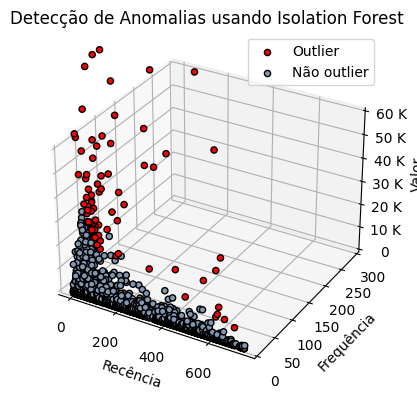

In [ ]:
fig = plt.figure(figsize=(4.5, 8))
ax = fig.add_subplot(111, projection='3d')

ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.1,
        alpha = 0.1)


ax.scatter(rfv[rfv['Outlier'] == -1]['Recencia'],
           rfv[rfv['Outlier'] == -1]['Frequencia'],
           rfv[rfv['Outlier'] == -1]['Valor'],
           c='red', label='Outlier', edgecolor='black', alpha=1)

ax.scatter(rfv[rfv['Outlier'] == 1]['Recencia'],
            rfv[rfv['Outlier'] == 1]['Frequencia'],
            rfv[rfv['Outlier'] == 1]['Valor'],
            c='#8297B0', label='Não outlier',edgecolor='black', alpha=1)

ax.set_xlabel('Recência')
ax.set_ylabel('Frequência')
ax.set_zlabel('Valor')
ax.legend()
plt.title('Detecção de Anomalias usando Isolation Forest')
# fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

ax.set_ylim([0, 300])
ax.set_zlim([0, 60000])

def formata_eixo(value, tick_number):
    if value >= 1e6:
        return f'{value / 1e6:.0f} M'
    elif value >= 1e3:
        return f'{value / 1e3:.0f} K'
    else:
        return f'{value:.0f}'

ax.zaxis.set_major_formatter(FuncFormatter(formata_eixo))

plt.show()

In [ ]:
rfv_scaled.groupby('Outlier').size()

,0
Outlier,
-1,89
1,5790


In [ ]:
# Remove os clientes classificados como outliers
rfv = rfv[(rfv['Outlier'] == 1)]
rfv_scaled = rfv_scaled[rfv_scaled['Outlier'] == 1]

### Correlação entre as variáveis

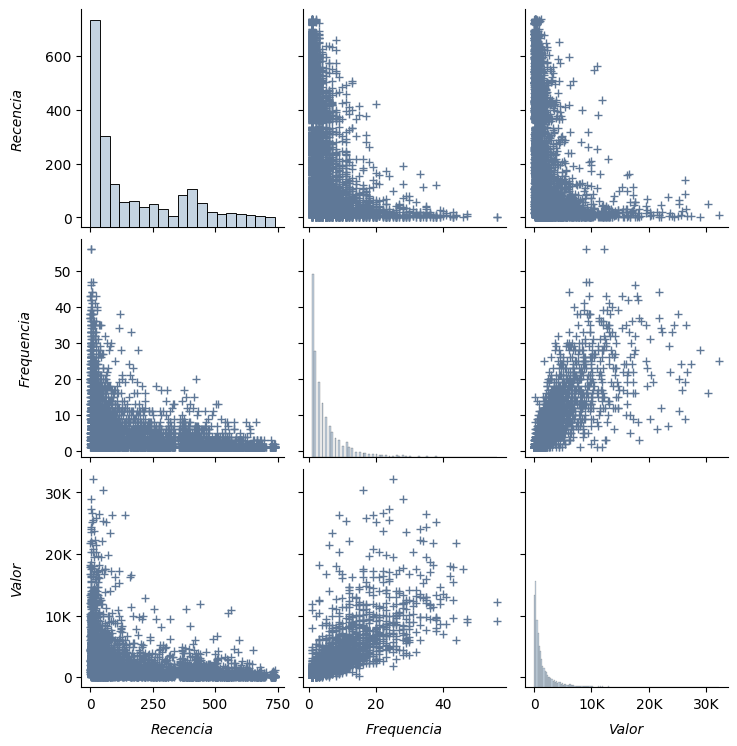

In [ ]:
g = sns.pairplot(
    rfv[['Recencia', 'Frequencia', 'Valor']],
    plot_kws=dict(marker="+", linewidth=1, color = '#5F7897'),
    diag_kws=dict(color = '#B1C5D8')
)

def formatar_valor(value, tick_number):
    if value > 4000:
        return f'{value/1000:.0f}K'
    else:
        return f'{value:.0f}'

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(formatar_valor))
    ax.xaxis.set_major_formatter(FuncFormatter(formatar_valor))

# Centralizando os nomes dos eixos x e y
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=10, labelpad=8, style='italic', ha='center')
    ax.set_ylabel(ax.get_ylabel(), fontsize=10, labelpad=20, style='italic', va='center')

plt.show()

In [ ]:
# Teste de Normalidade de Komolgorov
stat_recencia, p_recencia = stats.kstest(rfv['Recencia'], 'norm', args=(rfv['Recencia'].mean(), rfv['Recencia'].std()))
stat_frequencia, p_frequencia = stats.kstest(rfv['Frequencia'], 'norm', args=(rfv['Frequencia'].mean(), rfv['Frequencia'].std()))
stat_valor, p_valor = stats.kstest(rfv['Valor'], 'norm', args=(rfv['Valor'].mean(), rfv['Valor'].std()))

print(f'Recência - Estatística: {stat_recencia}, Valor p: {p_recencia}')
print(f'Frequência - Estatística: {stat_frequencia}, Valor p: {p_frequencia}')
print(f'Valor - Estatística: {stat_valor}, Valor p: {p_valor}')

def checar_normalidade(p):
    return "Normal" if p >= 0.01 else "Não normal"

print(f'Recência: {checar_normalidade(p_recencia)}')
print(f'Frequência: {checar_normalidade(p_frequencia)}')
print(f'Valor: {checar_normalidade(p_valor)}')

Recência - Estatística: 0.19319693498009544, Valor p: 8.921399632159513e-190
Frequência - Estatística: 0.24917406042918266, Valor p: 3.4305636e-317
Valor - Estatística: 0.2647677143948344, Valor p: 0.0
Recência: Não normal
Frequência: Não normal
Valor: Não normal


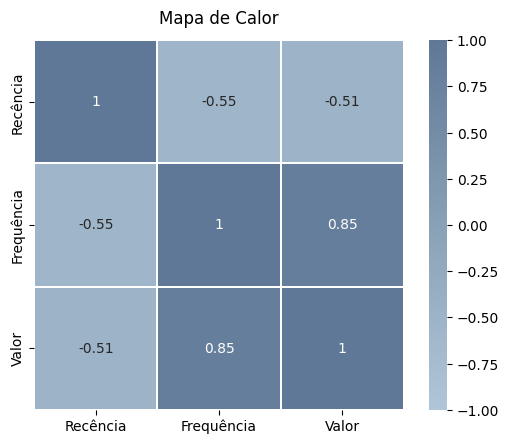

In [ ]:
corr_spearman = rfv[['Recencia','Frequencia','Valor']].corr(method='spearman')

custom_cmap = LinearSegmentedColormap.from_list(
    'custom_cmap',
    ['#B1C5D8', '#89A1B6', '#5F7897'],
    N=256)

heatmap = sns.heatmap(
    corr_spearman,
    cmap=custom_cmap,
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.01,
    annot=True,
    xticklabels=['Recência', 'Frequência', 'Valor'],
    yticklabels=['Recência', 'Frequência', 'Valor'],
)

heatmap.set_title('Mapa de Calor', fontdict={'fontsize':12,'color':'black'}, pad=12, loc='center')
plt.show()

In [ ]:
# Teste p
resultados_spearman = {}
for col1 in rfv[['Recencia','Frequencia','Valor']].columns:
    for col2 in rfv[['Recencia','Frequencia','Valor']].columns:
        if col1 != col2:
            corr, p_value = stats.spearmanr(rfv[['Recencia','Frequencia','Valor']][col1], rfv[['Recencia','Frequencia','Valor']][col2])
            resultados_spearman[(col1, col2)] = (corr, p_value)

for (var1, var2), (corr, p_value) in resultados_spearman.items():
    print(f'Correlação de Spearman entre {var1} e {var2}: {corr}, p-valor: {p_value}')

Correlação de Spearman entre Recencia e Frequencia: -0.5530036050826825, p-valor: 0.0
Correlação de Spearman entre Recencia e Valor: -0.5061150523201153, p-valor: 0.0
Correlação de Spearman entre Frequencia e Recencia: -0.5530036050826825, p-valor: 0.0
Correlação de Spearman entre Frequencia e Valor: 0.8543307379790552, p-valor: 0.0
Correlação de Spearman entre Valor e Recencia: -0.5061150523201154, p-valor: 0.0
Correlação de Spearman entre Valor e Frequencia: 0.8543307379790553, p-valor: 0.0


### Definição dos parâmetros

**K-means**


---



---




In [ ]:
# Método do cotovelo

tempo_inicial = time.time()
eixo_x = []
distorcao = []
valores_silhueta = []
valores_davies_bouldin = []
calinski_harabasz = []


for k in range(2,13):
    kmeans = KMeans(n_clusters = k, algorithm='lloyd', copy_x=True, init='k-means++', max_iter=300, n_init='auto', random_state=42, tol=0.0001, verbose=0)
    kmeans.fit(rfv_scaled)
    distorcao.append(kmeans.inertia_)
    eixo_x.append(k)
    valores_silhueta.append(silhouette_score(rfv_scaled, kmeans.labels_))
    valores_davies_bouldin.append(davies_bouldin_score(rfv_scaled, kmeans.labels_))
    calinski_harabasz.append(calinski_harabasz_score(rfv_scaled, kmeans.labels_))

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=eixo_x, y=distorcao, mode='lines+markers', name='Distorção', connectgaps=True, marker=dict(size=8, color='#5F7897')), row=1, col=1)
fig.update_layout(title='Método do Cotovelo',title_font=dict(size=21, color='black'), xaxis_title='Número de Clusters (k)', yaxis_title='SSE', height=400, width=800, font=dict(size=13,color='black'), title_x=.5, template='plotly_white')
fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(
    x=eixo_x,
    y=valores_silhueta,
    mode='lines+markers',
    name='Índice de Silhueta',
    marker=dict(color='#313E4D', size=8),
    line=dict(color='#313E4D', width=2)))

fig.add_trace(go.Scatter(
    x=eixo_x,
    y=valores_davies_bouldin,
    mode='lines+markers',
    name='Índice Davies-Bouldin',
    marker=dict(color='#A8B6C8', size=8),
    line=dict(color='#A8B6C8', width=2)))
fig.update_layout(
    xaxis_title='Número de Clusters (k)',
    yaxis_title='Coeficiente',
    title_font=dict(size=20, color='black'),
    height=350,
    width=1000,
    font=dict(size=13, color = 'black'),
    title=dict(text='Avaliação de Clusters: Índice de Silhueta vs Davies-Bouldin', x=0.5),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5
    ),
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        zeroline=False
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        zeroline=False
    ),
    plot_bgcolor='white'
)

fig.show()

tempo_final = time.time()

print(f"({tempo_final - tempo_inicial} segundos)")

(9.34836745262146 segundos)


In [ ]:
rfv

,Cliente,Recencia,Frequencia,Valor,Outlier
1,12347,2,8,4921,1
2,12348,75,5,2019,1
3,12349,18,4,4428,1
4,12350,310,1,334,1
5,12351,375,1,300,1
...,...,...,...,...,...
5874,18283,3,22,2664,1
5875,18284,431,1,461,1
5876,18285,660,1,427,1
5877,18286,476,2,1296,1


**Classificação Hierárquica**


---



---




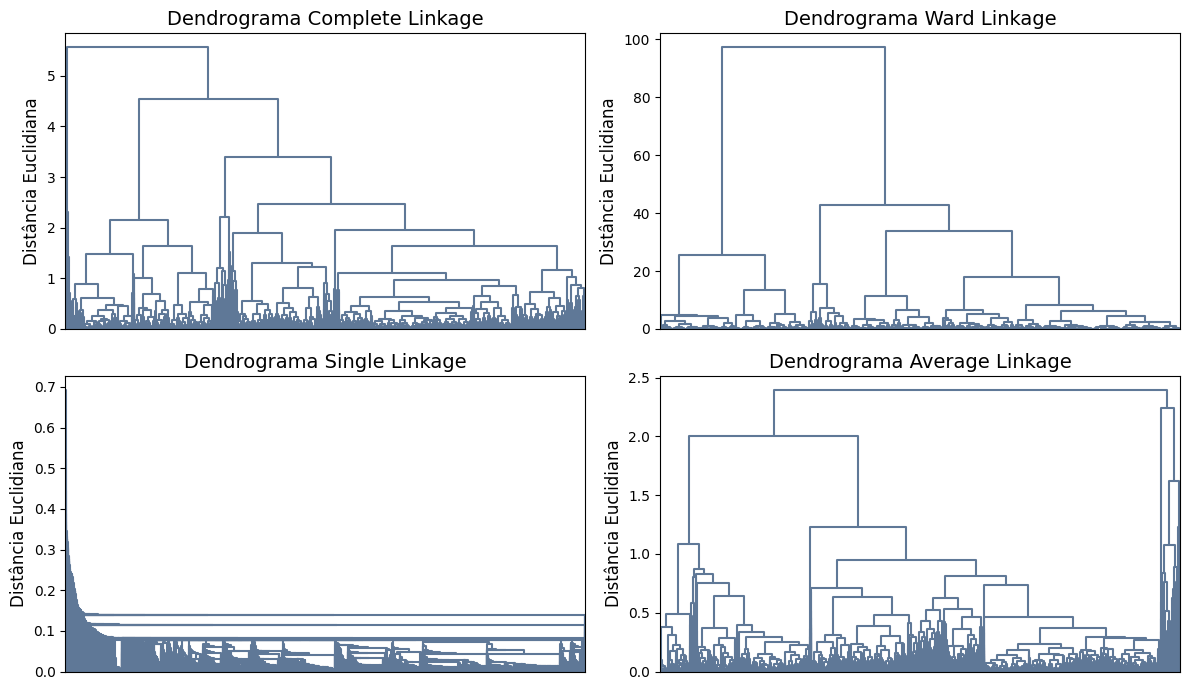

In [ ]:
tempo_inicial = time.time()

plt.figure(figsize=(12, 7))


plt.subplot(2, 2, 1)  # Subplot 1
dend_compl = sch.linkage(rfv_scaled, method='complete', metric='euclidean')
sch.dendrogram(dend_compl, color_threshold=8, link_color_func=lambda x: '#5F7897', no_labels=True)
plt.title('Dendrograma Complete Linkage', fontsize=14)
# plt.xlabel('Índices dos Dados', fontsize=12)
plt.ylabel('Distância Euclidiana', fontsize=12)

plt.subplot(2, 2, 2)  # Subplot 2
dend_ward = sch.linkage(rfv_scaled, method='ward', metric='euclidean')
sch.dendrogram(dend_ward, color_threshold=8, link_color_func=lambda x: '#5F7897', no_labels=True)
plt.title('Dendrograma Ward Linkage', fontsize=14)
# plt.xlabel('Índices dos Dados', fontsize=12)
plt.ylabel('Distância Euclidiana', fontsize=12)

plt.subplot(2, 2, 3)  # Subplot 3
dend_single = sch.linkage(rfv_scaled, method='single', metric='euclidean')
sch.dendrogram(dend_single, color_threshold=8, link_color_func=lambda x: '#5F7897', no_labels=True)
plt.title('Dendrograma Single Linkage', fontsize=14)
# plt.xlabel('Índices dos Dados', fontsize=12)
plt.ylabel('Distância Euclidiana', fontsize=12)

plt.subplot(2, 2, 4)  # Subplot 4
dend_average = sch.linkage(rfv_scaled, method='average', metric='euclidean')
sch.dendrogram(dend_average, color_threshold=8, link_color_func=lambda x: '#5F7897', no_labels=True)
plt.title('Dendrograma Average Linkage', fontsize=14)
# plt.xlabel('Índices dos Dados', fontsize=12)
plt.ylabel('Distância Euclidiana', fontsize=12)

plt.tight_layout()
plt.show()

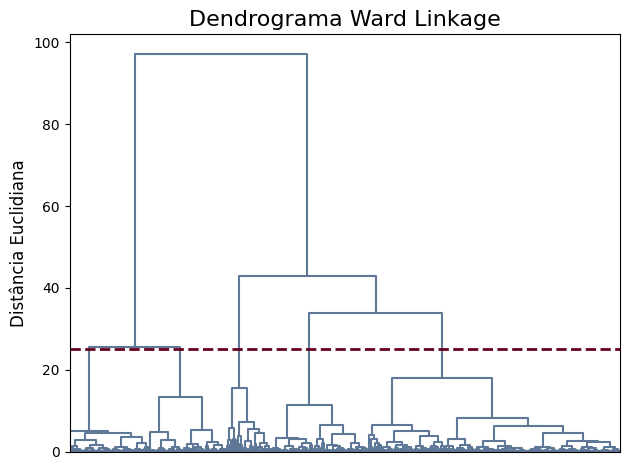

In [ ]:
dend_ward = sch.linkage(rfv_scaled, method='ward', metric='euclidean')
sch.dendrogram(dend_ward, color_threshold=8, link_color_func=lambda x: '#5F7897', no_labels=True)
plt.title('Dendrograma Ward Linkage', fontsize=16)
# plt.xlabel('Índices dos Dados', fontsize=12)
plt.ylabel('Distância Euclidiana', fontsize=12)
plt.axhline(y=25, color='#67001F', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

In [ ]:
linkage_matrix = linkage(rfv_scaled, method='ward', metric='euclidean')

alturas = [35,30,25,16,15,12,10,8]
# alturas = [10,8,6,4,2]
silhouette_scores = {}
davies_bouldin_scores = {}

for h in alturas:
    clusters = fcluster(linkage_matrix, t=h, criterion='distance')
    silhouette_avg = silhouette_score(rfv_scaled, clusters)
    davies_bouldin_avg = davies_bouldin_score(rfv_scaled, clusters)
    silhouette_scores[h] = silhouette_avg
    davies_bouldin_scores[h] = davies_bouldin_avg

print("Silhouette Scores:", silhouette_scores)
print("Davies-Bouldin Scores:", davies_bouldin_scores)

Silhouette Scores: {35: 0.5505242303468689, 30: 0.4822338902115289, 25: 0.4746622806088004, 16: 0.42324508296617674, 15: 0.4284476196574356, 12: 0.4236869813215139, 10: 0.41697075659904004, 8: 0.3769420096751267}
Davies-Bouldin Scores: {35: 0.6513450996618554, 30: 0.6805928776593431, 25: 0.6643357326391064, 16: 0.7439015189562097, 15: 0.7637333367974646, 12: 0.7630456555043668, 10: 0.7959875600797948, 8: 0.8494414234223999}


In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=alturas,
        y=[silhouette_scores[h] for h in alturas],
        mode='lines+markers',
        name='índice de Silhueta',
        marker=dict(color='#313E4D', size=8),
        line=dict(color='#313E4D', width=2)))

fig.add_trace(
    go.Scatter(
        x=alturas,
        y=[davies_bouldin_scores[h] for h in alturas],
        mode='lines+markers',
        name='índice Davies-Bouldin',
        marker=dict(color='#A8B6C8', size=8),
        line=dict(color='#A8B6C8', width=2)))

fig.update_layout(
    title={
        'text': 'Avaliação de Clusters: Índice de Silhueta vs Davies-Bouldin',
        'font': dict(size=20, color='black'),
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title='Altura do Corte',
    yaxis_title='Coeficiente',
    height=350,
    width=1000,
    font=dict(size=13, color='black'),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5
    ),
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        zeroline=False
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        zeroline=False
    ),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig.show()

tempo_final = time.time()

print(f"({tempo_final - tempo_inicial} segundos)")

(51.78963780403137 segundos)


**DBSCAN**


---



---



In [ ]:
tempo_inicial = time.time()

# eps_values = np.arange(0.05, 1.5, 0.05)
# min_samples_values = range(6, 579)

# results = []

# for eps in eps_values:
#     print(eps)
#     for min_samples in min_samples_values:
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         labels = dbscan.fit_predict(rfv_scaled)
#         n_clusters = len(set(labels))

#         if n_clusters > 2:
#             silhouette_avg = silhouette_score(rfv_scaled, labels)
#             davies_bouldin = davies_bouldin_score(rfv_scaled, labels)
#             results.append({
#             'eps': eps,
#             'min_samples': min_samples,
#             'n_clusters': n_clusters,
#             'silhouette_score': silhouette_avg,
#             'davies_bouldin_score': davies_bouldin
#         })


In [ ]:
# results_df = pd.DataFrame(results)
# df = results_df

In [ ]:
# df.head()

In [ ]:
df = pd.read_csv('resultado_dbscan.csv')
df =df[df['min_samples']>=6]
df

,eps,min_samples,n_clusters,silhouette_score,davies_bouldin_score,combined_score
4,0.050000,6,51,-0.370734,2.081607,-2.452342
5,0.050000,7,45,-0.369668,2.047592,-2.417260
6,0.050000,8,44,-0.387310,2.022225,-2.409535
7,0.050000,9,39,-0.384281,2.136191,-2.520472
8,0.050000,10,34,-0.387565,2.179167,-2.566732
...,...,...,...,...,...,...
1364,0.300000,575,3,0.391136,1.946079,-1.554943
1365,0.300000,576,3,0.390956,1.944905,-1.553948
1366,0.300000,577,3,0.390229,1.942691,-1.552462
1367,0.300000,578,3,0.389148,1.931405,-1.542257


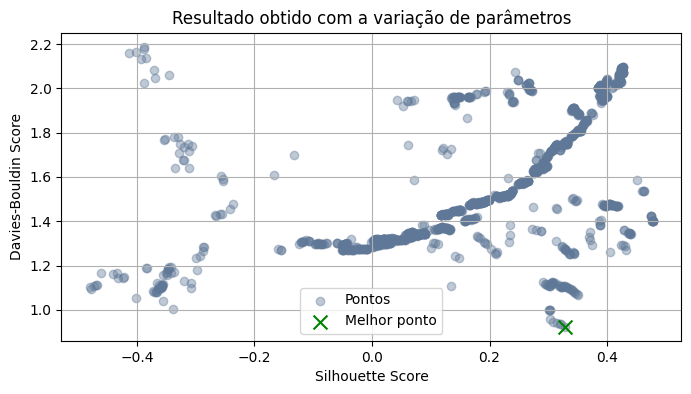

In [ ]:
# Plota os resultados gerado pela combinação dos parâmetros
best_index = ((df['silhouette_score'] - 1).abs() + df['davies_bouldin_score']).idxmin()

plt.figure(figsize=(8, 4))
plt.scatter( df['silhouette_score'],df['davies_bouldin_score'], color='#5F7897', alpha=0.4, label='Pontos', marker="o")
plt.scatter(df['silhouette_score'][best_index], df['davies_bouldin_score'][best_index], color='Green',
            s=100, label='Melhor ponto', marker="x")

plt.title('Resultado obtido com a variação de parâmetros')
plt.xlabel('Silhouette Score')
plt.ylabel('Davies-Bouldin Score')

plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
df[(df['silhouette_score'] == df['silhouette_score'][best_index]) &  (df['davies_bouldin_score'] == df['davies_bouldin_score'][best_index])]


tempo_final = time.time()

print(f"({tempo_final - tempo_inicial} segundos)")


(716.885201215744 segundos)


### Aplicação nos modelos

In [ ]:
kmeans = KMeans(n_clusters=6, algorithm='lloyd', copy_x=True, init='k-means++', max_iter=300, n_init='auto', random_state=42, tol=0.0001, verbose=0)
kmeans.fit(rfv_scaled)

KMeans(n_clusters=6, random_state=42)

In [ ]:
aglomerativo = AgglomerativeClustering(n_clusters=5, linkage='ward')
indica_cluster_comp = aglomerativo.fit_predict(rfv_scaled)

In [ ]:
dbscan = DBSCAN(eps=0.1, min_samples=83)
dbscan.fit(rfv_scaled)

DBSCAN(eps=0.1, min_samples=83)

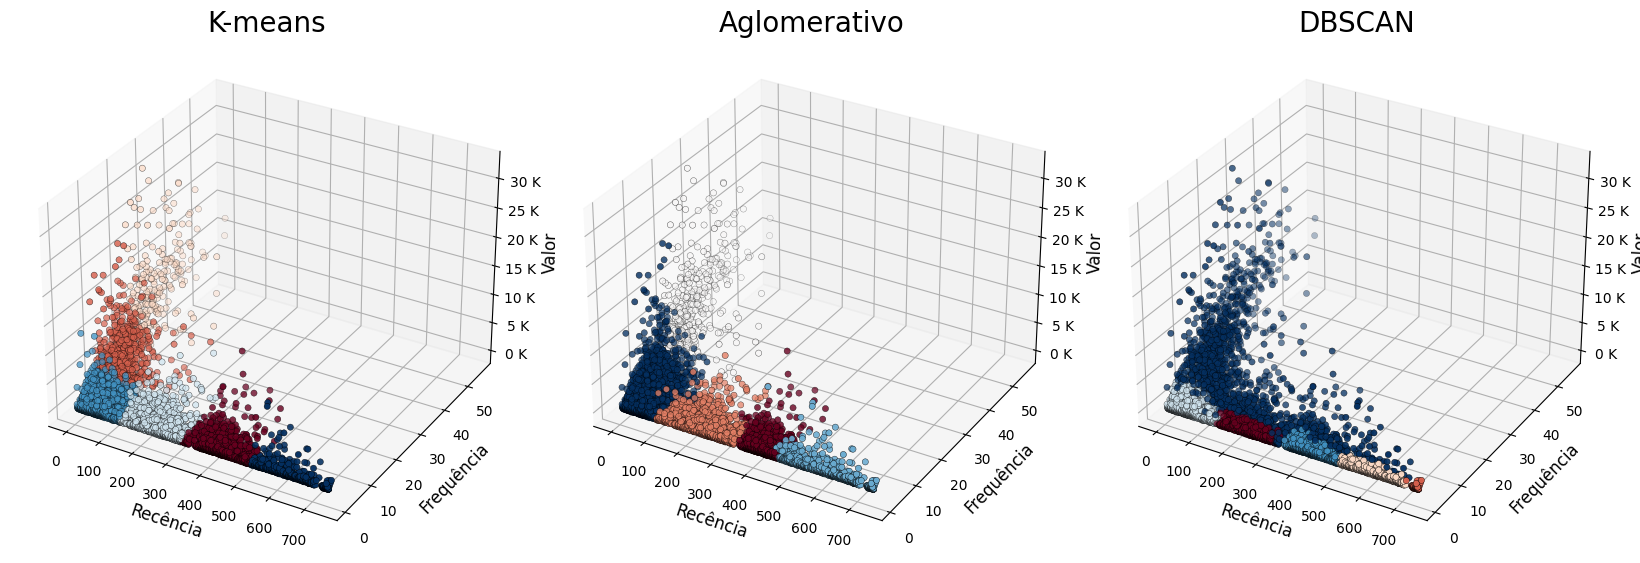

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16.5, 5.5), subplot_kw={'projection': '3d'})

def format_value(x, pos):
    return f"{int(x/1000)} K"

# Gráfico 1: K-means
scatter1 = axs[0].scatter(rfv['Recencia'], rfv['Frequencia'], rfv['Valor'], c=kmeans.labels_, cmap='RdBu_r', edgecolor='black', linewidth=0.3)
axs[0].set_title('K-means',fontsize=20,color="black")
axs[0].set_xlabel('Recência',fontsize=12)
axs[0].set_ylabel('Frequência',fontsize=12)
axs[0].set_zlabel('Valor',fontsize=12)
axs[0].zaxis.set_major_formatter(plt.FuncFormatter(format_value))

# Gráfico 2: Aglomerativo
scatter2 = axs[1].scatter(rfv['Recencia'], rfv['Frequencia'], rfv['Valor'], c=aglomerativo.labels_, cmap='RdBu_r', edgecolor='black', linewidth=0.3)
axs[1].set_title('Aglomerativo',fontsize=20,color="black")
axs[1].set_xlabel('Recência',fontsize=12)
axs[1].set_ylabel('Frequência',fontsize=12)
axs[1].set_zlabel('Valor',fontsize=12)
axs[1].zaxis.set_major_formatter(plt.FuncFormatter(format_value))

# Gráfico 3: DBSCAN
scatter3 = axs[2].scatter(rfv['Recencia'], rfv['Frequencia'], rfv['Valor'], c=dbscan.labels_, cmap='RdBu_r', edgecolor='black', linewidth=0.3)
axs[2].set_title('DBSCAN',fontsize=20,color="black")
axs[2].set_xlabel('Recência',fontsize=12)
axs[2].set_ylabel('Frequência',fontsize=12)
axs[2].set_zlabel('Valor',fontsize=12)
axs[2].zaxis.set_major_formatter(plt.FuncFormatter(format_value))

# Ajusta o layout e mostra a figura
plt.tight_layout()
plt.show()

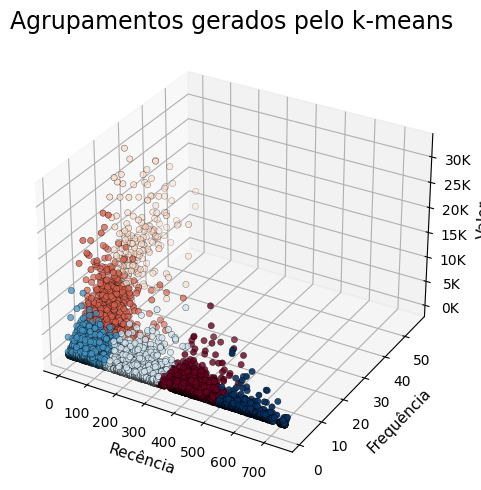

In [ ]:

fig = plt.figure(figsize=(12, 5))
axs = fig.add_subplot(111, projection='3d')

def format_value(x, pos):
    return f"{int(x/1000)}K"

scatter1 = axs.scatter(rfv['Recencia'], rfv['Frequencia'], rfv['Valor'], c=kmeans.labels_, cmap='RdBu_r', edgecolor='black', linewidth=0.3)

axs.set_title('Agrupamentos gerados pelo k-means',fontsize=17)
axs.set_xlabel('Recência',fontsize=11)
axs.set_ylabel('Frequência',fontsize=11)
axs.set_zlabel('Valor',fontsize=11)

axs.zaxis.set_major_formatter(plt.FuncFormatter(format_value))

plt.tight_layout()
plt.show()

### Análise do resultado

In [ ]:
rfv['cluster_dbscan'] = dbscan.labels_
rfv['cluster_kmeans'] = kmeans.labels_
rfv['cluster_aglomerativo'] = aglomerativo.labels_

**Uniformidade dos agrupamentos**

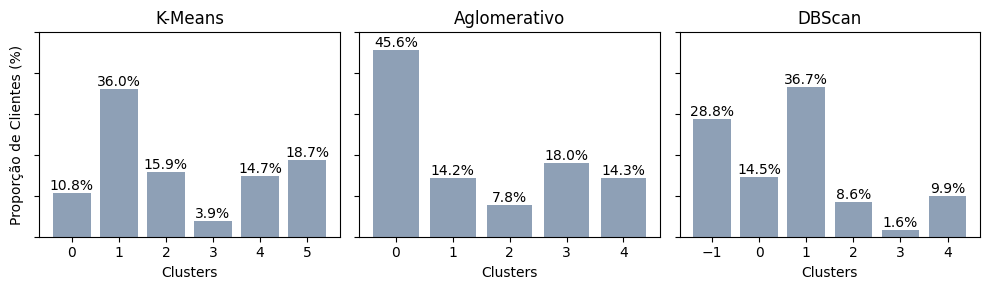

In [ ]:
plt.figure(figsize=(10, 3))

counts_kmeans = rfv['cluster_kmeans'].value_counts(normalize=True).sort_index()
counts_aglomerativo = rfv['cluster_aglomerativo'].value_counts(normalize=True).sort_index()
counts_dbscan = rfv['cluster_dbscan'].value_counts(normalize=True).sort_index()

percent_kmeans = counts_kmeans * 100
percent_aglomerativo = counts_aglomerativo * 100
percent_dbscan = counts_dbscan * 100

y_limite_superior = 0.5
plt.subplot(1, 3, 1)
bars_kmeans = plt.bar(counts_kmeans.index, counts_kmeans.values,
                      color='#5F7897', alpha=0.7)
plt.title('K-Means')
plt.xlabel('Clusters')
plt.ylabel('Proporção de Clientes (%)')
plt.ylim(0, y_limite_superior)
plt.grid(False)
plt.gca().set_yticklabels([])

for bar, percent in zip(bars_kmeans, percent_kmeans):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percent:.1f}%',
             ha='center', va='bottom', fontsize=10)

plt.subplot(1, 3, 2)
bars_aglomerativo = plt.bar(counts_aglomerativo.index, counts_aglomerativo.values,
                            color='#5F7897', alpha=0.7)
plt.title('Aglomerativo')
plt.xlabel('Clusters')
plt.ylim(0, y_limite_superior)
plt.grid(False)
plt.gca().set_yticklabels([])

for bar, percent in zip(bars_aglomerativo, percent_aglomerativo):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percent:.1f}%',
             ha='center', va='bottom', fontsize=10)

plt.subplot(1, 3, 3)
bars_dbscan = plt.bar(counts_dbscan.index, counts_dbscan.values,
                      color='#5F7897', alpha=0.7)
plt.title('DBScan')
plt.xlabel('Clusters')
plt.ylim(0, y_limite_superior)
plt.grid(False)
plt.gca().set_yticklabels([])

for bar, percent in zip(bars_dbscan, percent_dbscan):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percent:.1f}%',
             ha='center', va='bottom', fontsize=10)


plt.tight_layout()
plt.show()

**Similaridade entre Clusters**

In [ ]:
# pip install git+https://github.com/jqmviegas/jqm_cvi.git

  Cloning https://github.com/jqmviegas/jqm_cvi.git to /tmp/pip-req-build-2rm2vtrl
  Running command git clone --filter=blob:none --quiet https://github.com/jqmviegas/jqm_cvi.git /tmp/pip-req-build-2rm2vtrl
  Resolved https://github.com/jqmviegas/jqm_cvi.git to commit 9e1137d4f4df70c1287011e1a544b0c3fe36af36
  Preparing metadata (setup.py) ... done
  Created wheel for jqmcvi: filename=jqmcvi-1.0-cp310-cp310-linux_x86_64.whl size=421751 sha256=f097a82b672efebc920e0cf1a8ef7f76667279795c1e5a4c6e41dfd9971399a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-ywoys_9m/wheels/be/41/d1/f021173ed979d287d94299b802a9bee0d4d60cfa1c563a997f
Successfully built jqmcvi


In [ ]:
# import jqmcvi.base as base

In [ ]:
# rfv.head()

,Cliente,Recencia,Frequencia,Valor,Outlier,cluster_dbscan,cluster_kmeans,cluster_aglomerativo
1,12347,2,8,4921,1,-1,4,0
2,12348,75,5,2019,1,1,1,0
3,12349,18,4,4428,1,-1,1,0
4,12350,310,1,334,1,4,2,3
5,12351,375,1,300,1,0,5,4


In [ ]:
X = rfv_scaled[['Recencia', 'Frequencia', 'Valor']].values

silhouette_kmeans = silhouette_score(X, rfv['cluster_kmeans'])
davies_bouldin_kmeans = davies_bouldin_score(X, rfv['cluster_kmeans'])
calinski_harabasz_kmeans = calinski_harabasz_score(X, rfv['cluster_kmeans'])

# clus0_kmeans = X[rfv['cluster_kmeans'] == 0]
# clus1_kmeans = X[rfv['cluster_kmeans'] == 1]
# clus2_kmeans = X[rfv['cluster_kmeans'] == 2]
# clus3_kmeans = X[rfv['cluster_kmeans'] == 3]
# clus4_kmeans = X[rfv['cluster_kmeans'] == 4]
# clus5_kmeans = X[rfv['cluster_kmeans'] == 5]
# cluster_list_kmeans = [clus0_kmeans, clus1_kmeans, clus2_kmeans,clus3_kmeans,clus4_kmeans,clus5_kmeans]

# dunn_kmeans = base.dunn(cluster_list_kmeans)

print(f"Métrica de Silhueta para K-Means: {silhouette_kmeans}")
print(f"Índice de Davies-Bouldin para K-Means: {davies_bouldin_kmeans}")
print(f"Coeficiente de Calinski-Harabasz para K-Means: {calinski_harabasz_kmeans}")
# print(f"Índice de Dunn para K-Means: {dunn_kmeans}")


Métrica de Silhueta para K-Means: 0.49972051190336614
Índice de Davies-Bouldin para K-Means: 0.6621258342609322
Coeficiente de Calinski-Harabasz para K-Means: 13016.345109604099


In [ ]:
silhouette_aglomerativo = silhouette_score(X, rfv['cluster_aglomerativo'])
davies_bouldin_aglomerativo = davies_bouldin_score(X, rfv['cluster_aglomerativo'])
calinski_harabasz_aglomerativo = calinski_harabasz_score(X, rfv['cluster_aglomerativo'])

# clus0_aglomerativo = X[rfv['cluster_aglomerativo'] == 0]
# clus1_aglomerativo = X[rfv['cluster_aglomerativo'] == 1]
# clus2_aglomerativo = X[rfv['cluster_aglomerativo'] == 2]
# clus3_aglomerativo = X[rfv['cluster_aglomerativo'] == 3]
# clus4_aglomerativo = X[rfv['cluster_aglomerativo'] == 4]
# cluster_list_aglomerativo = [clus0_aglomerativo, clus1_aglomerativo, clus2_aglomerativo, clus3_aglomerativo, clus4_aglomerativo]

# dunn_aglomerativo = base.dunn(cluster_list_aglomerativo)

print(f"Métrica de Silhueta para Aglomerativo: {silhouette_aglomerativo}")
print(f"Índice de Davies-Bouldin para Aglomerativo: {davies_bouldin_aglomerativo}")
print(f"Coeficiente de Calinski-Harabasz para Aglomerativo: {calinski_harabasz_aglomerativo}")
# print(f"Índice de Dunn para Aglomerativo: {dunn_aglomerativo}")

Métrica de Silhueta para Aglomerativo: 0.4746622806088005
Índice de Davies-Bouldin para Aglomerativo: 0.6643357326391071
Coeficiente de Calinski-Harabasz para Aglomerativo: 10637.711300729557


In [ ]:
silhouette_dbscan = silhouette_score(X, rfv['cluster_dbscan'])
davies_bouldin_dbscan = davies_bouldin_score(X, rfv['cluster_dbscan'])
calinski_harabasz_dbscan = calinski_harabasz_score(X, rfv['cluster_dbscan'])

# clus_1_dbscan = X[rfv['cluster_dbscan'] == -1]
# clus0_dbscan = X[rfv['cluster_dbscan'] == 0]
# clus1_dbscan = X[rfv['cluster_dbscan'] == 1]
# clus2_dbscan = X[rfv['cluster_dbscan'] == 2]
# clus3_dbscan = X[rfv['cluster_dbscan'] == 3]
# clus4_dbscan = X[rfv['cluster_dbscan'] == 4]
# cluster_list_dbscan = [clus_1_dbscan, clus0_dbscan, clus1_dbscan, clus2_dbscan, clus3_dbscan, clus4_dbscan]

# dunn_dbscan = base.dunn(cluster_list_dbscan)

print(f"Métrica de Silhueta para DBSCAN: {silhouette_dbscan}")
print(f"Índice de Davies-Bouldin para DBSCAN: {davies_bouldin_dbscan}")
print(f"Coeficiente de Calinski-Harabasz para DBSCAN: {calinski_harabasz_dbscan}")
# print(f"Índice de Dunn para DBSCAN: {dunn_dbscan}")

Métrica de Silhueta para DBSCAN: 0.32920374661846535
Índice de Davies-Bouldin para DBSCAN: 0.9238573170611163
Coeficiente de Calinski-Harabasz para DBSCAN: 3039.670735560349


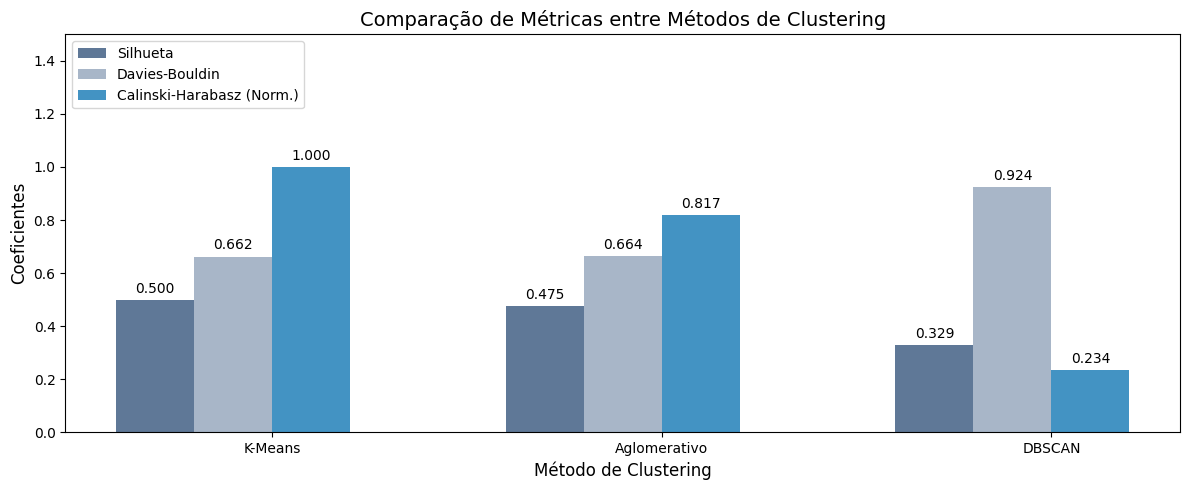

In [ ]:
metodos = ['K-Means', 'Aglomerativo', 'DBSCAN']
davies_bouldin_scores = [davies_bouldin_kmeans, davies_bouldin_aglomerativo, davies_bouldin_dbscan]
silhouette_scores = [silhouette_kmeans, silhouette_aglomerativo, silhouette_dbscan]
calinski_harabasz_scores = [calinski_harabasz_kmeans, calinski_harabasz_aglomerativo, calinski_harabasz_dbscan]
# dunn_scores = [dunn_kmeans, dunn_aglomerativo, dunn_dbscan]

max_calinski = max(calinski_harabasz_scores)
calinski_harabasz_scores_normalized = [score / max_calinski for score in calinski_harabasz_scores]

bar_width = 0.2
index = np.arange(len(metodos))

fig, ax = plt.subplots(figsize=(12, 5))

bars2 = ax.bar(index - 1.5 * bar_width, silhouette_scores, width=bar_width, color='#5F7897', label='Silhueta')
bars1 = ax.bar(index - 0.5 * bar_width, davies_bouldin_scores, width=bar_width, color='#A8B6C8', label='Davies-Bouldin')
bars3 = ax.bar(index + 0.5 * bar_width, calinski_harabasz_scores_normalized, width=bar_width, color='#4393C3', label='Calinski-Harabasz (Norm.)')
# bars4 = ax.bar(index + 1.5 * bar_width, dunn_scores, width=bar_width, color='#031E3C', label='Dunn')

# Função para adicionar os rótulos nas barras
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Deslocamento do texto
                    textcoords="offset points",
                    ha='center', va='bottom')

# Adicionar os valores em cima das barras
autolabel(bars1)
autolabel(bars2)
autolabel(bars3)
# autolabel(bars4)

# Configuração dos eixos
ax.set_xlabel('Método de Clustering', fontsize=12)
ax.set_ylabel('Coeficientes', fontsize=12)
ax.set_title('Comparação de Métricas entre Métodos de Clustering', fontsize=14)
ax.set_xticks(index)
ax.set_xticklabels(metodos)
ax.legend(loc='upper left')

# Exibir a grade levemente
# ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

ax.grid(False)
ax.set_ylim([0, 1.5])

# Ajuste no layout para melhor visualização
plt.tight_layout()

# Mostrar o gráfico
plt.show()

**Visão qualitativa dos clusters**

Recência x Frequência

In [ ]:
fig = px.scatter(rfv, x="Recencia", y="Frequencia", color=kmeans.labels_,
                  color_continuous_scale="RdBu_r",
                  height=400, width=400, labels={'Recencia': 'Recência', 'Frequencia': 'Frequência'})
fig.update_layout(
    title_text='K-means',
    title_x=0.5,
    font=dict(size=13),
    showlegend=True
)
fig.update_traces(marker=dict(size=8, line=dict(width=0.2, color='Black')))

fig.show()

In [ ]:
fig = px.scatter(rfv, x="Recencia", y="Frequencia", color=aglomerativo.labels_,
                  color_continuous_scale="RdBu_r",
                  height=400, width=400, labels={'Recencia': 'Recência', 'Frequencia': 'Frequência'})
fig.update_layout(
    title_text='Aglomerativo',
    title_x=0.5,
    font=dict(size=13),
    showlegend=True
)
fig.update_traces(marker=dict(size=8, line=dict(width=0.2, color='Black')))

fig.show()

In [ ]:
fig = px.scatter(rfv, x="Recencia", y="Frequencia", color=dbscan.labels_,
                  color_continuous_scale="RdBu_r",
                  height=400, width=400, labels={'Recencia': 'Recência', 'Frequencia': 'Frequência'})
fig.update_layout(
    title_text='DBSCAN',
    title_x=0.5,
    font=dict(size=13),
    showlegend=True
)
fig.update_traces(marker=dict(size=8, line=dict(width=0.2, color='Black')))

fig.show()

Valor x Frequência

In [ ]:
fig = px.scatter(rfv, x="Valor", y="Frequencia", color=kmeans.labels_,
                  color_continuous_scale="RdBu_r",
                  height=400, width=400, labels={'Recencia': 'Recência', 'Frequencia': 'Frequência'})
fig.update_layout(
    title_text='K-Means',
    title_x=0.5,
    font=dict(size=13),
    showlegend=True
)
fig.update_traces(marker=dict(size=8, line=dict(width=0.2, color='Black')))

fig.show()

In [ ]:
fig = px.scatter(rfv, x="Valor", y="Frequencia", color=aglomerativo.labels_,
                  color_continuous_scale="RdBu_r",
                  height=400, width=400, labels={'Recencia': 'Recência', 'Frequencia': 'Frequência'})
fig.update_layout(
    title_text='Aglomerativo',
    title_x=0.5,
    font=dict(size=13),
    showlegend=True
)
fig.update_traces(marker=dict(size=8, line=dict(width=0.2, color='Black')))

fig.show()

In [ ]:
fig = px.scatter(rfv, x="Valor", y="Frequencia", color=dbscan.labels_,
                  color_continuous_scale="RdBu_r",
                  height=400, width=400, labels={'Recencia': 'Recência', 'Frequencia': 'Frequência'})
fig.update_layout(
    title_text='DBSCAN',
    title_x=0.5,
    font=dict(size=13),
    showlegend=True
)
fig.update_traces(marker=dict(size=8, line=dict(width=0.2, color='Black')))

fig.show()

Valor x Recência

In [ ]:
fig = px.scatter(rfv, x="Valor", y="Recencia", color=kmeans.labels_,
                  color_continuous_scale="RdBu_r",
                  height=400, width=400, labels={'Recencia': 'Recência', 'Frequencia': 'Frequência'})
fig.update_layout(
    title_text='K-Means',
    title_x=0.5,
    font=dict(size=13),
    showlegend=True
)
fig.update_traces(marker=dict(size=8, line=dict(width=0.2, color='Black')))

fig.show()

In [ ]:
fig = px.scatter(rfv, x="Valor", y="Recencia", color=aglomerativo.labels_,
                  color_continuous_scale="RdBu_r",
                  height=400, width=400, labels={'Recencia': 'Recência', 'Frequencia': 'Frequência'})
fig.update_layout(
    title_text='Aglomerativo',
    title_x=0.5,
    font=dict(size=13),
    showlegend=True
)
fig.update_traces(marker=dict(size=8, line=dict(width=0.2, color='Black')))

fig.show()

In [ ]:
fig = px.scatter(rfv, x="Valor", y="Recencia", color=dbscan.labels_,
                  color_continuous_scale="RdBu_r",
                  height=400, width=400, labels={'Recencia': 'Recência', 'Frequencia': 'Frequência'})
fig.update_layout(
    title_text='DBSCAN',
    title_x=0.5,
    font=dict(size=13),
    showlegend=True
)
fig.update_traces(marker=dict(size=8, line=dict(width=0.2, color='Black')))

fig.show()

### Resultado

In [ ]:
cluster_kmeans = rfv.groupby('cluster_kmeans').agg({'Recencia': 'mean', 'Frequencia': 'mean', 'Valor': 'mean'}).round(1).reset_index().sort_values(by='Valor')
cluster_kmeans

cluster_kmeans = pd.DataFrame(cluster_kmeans)
cluster_kmeans

cluster_kmeans = cluster_kmeans.sort_values(by='cluster_kmeans')
cluster_kmeans

,cluster_kmeans,Recencia,Frequencia,Valor
0,0,622.2,1.5,450.8
1,1,44.9,3.5,1184.2
2,2,222.0,3.2,1019.3
3,3,20.4,28.7,11693.9
4,4,36.8,12.2,4937.4
5,5,414.8,2.4,759.5


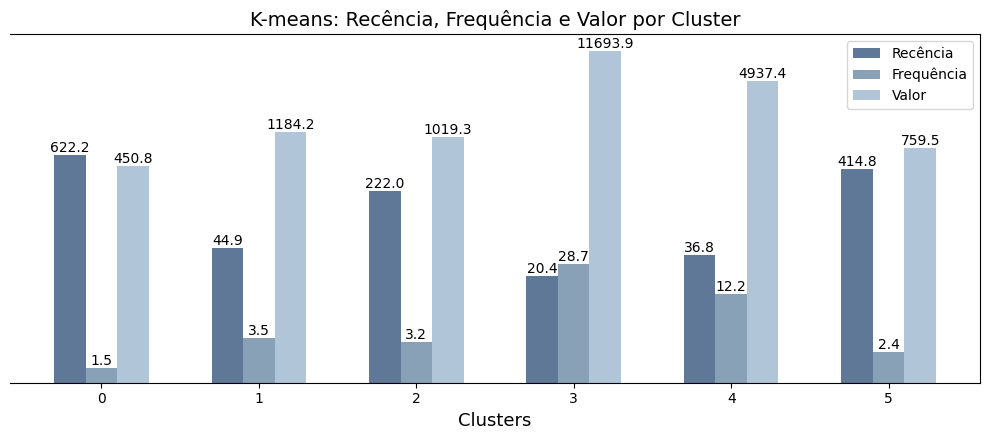

In [ ]:
clusters = cluster_kmeans['cluster_kmeans']
recencia = cluster_kmeans['Recencia']
frequencia = cluster_kmeans['Frequencia']
valor = cluster_kmeans['Valor']

recencia_log2 = [math.log(r) for r in recencia]
frequencia_log2 = [math.log(f) for f in frequencia]
valor_log2 = [math.log(v) for v in valor]

x = np.arange(len(clusters))
largura = 0.2

fig, ax = plt.subplots(figsize=(10, 4.5))

bars1 = ax.bar(x - largura, recencia_log2, largura, label='Recência', color='#5F7897')
bars2 = ax.bar(x, frequencia_log2, largura, label='Frequência', color='#89A1B6')
bars3 = ax.bar(x + largura, valor_log2, largura, label='Valor', color='#B1C5D8')

ax.set_yticks([])
ax.spines['left'].set_visible(False)

ax.set_xlabel('Clusters', fontsize=13)
ax.set_title('K-means: Recência, Frequência e Valor por Cluster', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(clusters)
ax.legend()

for i in range(len(clusters)):
    ax.text(i - largura, recencia_log2[i], f'{recencia[i]:.1f}', ha='center', va='bottom')
    ax.text(i, frequencia_log2[i], f'{frequencia[i]:.1f}', ha='center', va='bottom')
    ax.text(i + largura, valor_log2[i], f'{valor[i]:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
